In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/algerian-thyroid-disease-image/dataset thyroid'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Benign/tiroides207.jpg
/kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Benign/tiroides31 (68).jpg
/kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Benign/tiroides31 (22).jpg
/kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Benign/tiroides31 (97).jpg
/kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Benign/tiroides48.jpg
/kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Benign/tiroides277.jpg
/kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Benign/3_14 - Copy.jpg
/kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Benign/3_7.jpg
/kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Benign/tiroides58.jpg
/kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Benign/tiroides279.jpg
/kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Benign/tiroides31 (103).jpg
/kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Benign/t

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3
CLASS_NAMES = ['Benign', 'normal thyroid', 'Malignant']

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3
CLASS_NAMES = ['Benign', 'Malignant', 'normal thyroid']

Found 1937 files belonging to 3 classes.


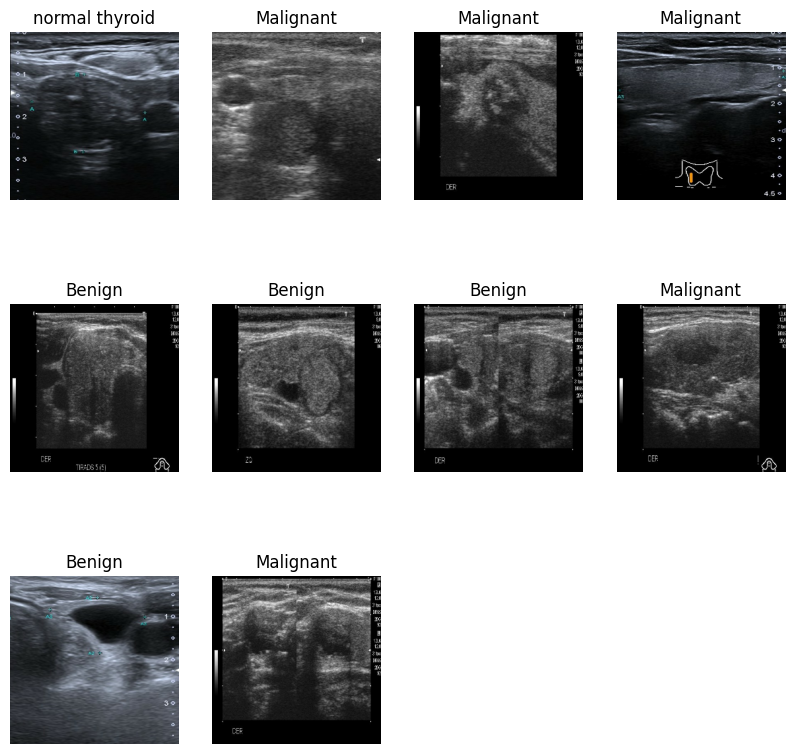

In [4]:
# Load dataset
data_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/algerian-thyroid-disease-image/dataset thyroid",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_names=CLASS_NAMES,
    label_mode='int'
)

# Display sample images
plt.figure(figsize=(10, 10))
for image_batch, label_batch in data_set.take(1):
    for i in range(10):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(CLASS_NAMES[label_batch[i]])
        plt.axis("off")
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

image_paths = []
labels = []
dataset_dir = "/kaggle/input/algerian-thyroid-disease-image/dataset thyroid"
# Loop through each class folder
for label in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, label)
    
    # Check if the class_dir is actually a directory
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            if img_file.endswith('.jpg') or img_file.endswith('.png'):  # Add other extensions if necessary
                image_paths.append(os.path.join(class_dir, img_file))
                labels.append(label)

# Create the DataFrame
df_shuffled = pd.DataFrame({'image': image_paths, 'label': labels})

#Shuffling the data
df = df_shuffled.sample(frac=1, random_state=42).reset_index(drop=True)

# Filter the data for the specified class names
df_filtered = df[df['label'].isin(CLASS_NAMES)]

# Split the filtered data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_filtered['image'], df_filtered['label'], test_size=0.25, random_state=42)

# Create dataframes for the training and test data
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})

# Encode the labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the image size and batch size
image_size = (50, 50)
batch_size = 32

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


 #Create generators for the training and test data
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

train_generator.class_indices = {class_name: i for i, class_name in enumerate(CLASS_NAMES)}
test_generator.class_indices = {class_name: i for i, class_name in enumerate(CLASS_NAMES)}


Found 1205 validated image filenames belonging to 3 classes.
Found 402 validated image filenames belonging to 3 classes.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Set the input shape for the model
input_shape = (50, 50, 3)

# Create a Sequential model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(CLASS_NAMES), activation='softmax'))  # Update output layer

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5339 - loss: 0.9102 - val_accuracy: 0.5622 - val_loss: 0.8773
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5078 - loss: 0.9039 - val_accuracy: 0.5672 - val_loss: 0.8697
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.5485 - loss: 0.8629 - val_accuracy: 0.5821 - val_loss: 0.8359
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.5827 - loss: 0.8442 - val_accuracy: 0.6045 - val_loss: 0.8040
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.5623 - loss: 0.8711 - val_accuracy: 0.5896 - val_loss: 0.8135
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.5625 - loss: 0.8416 - val_accuracy: 0.5796 - val_loss: 0.8273
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.5681 - loss: 0.8488 - val_accuracy: 0.5945 - val_loss: 0.8004
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.5716 - loss: 0.8408 - val_accuracy: 0.

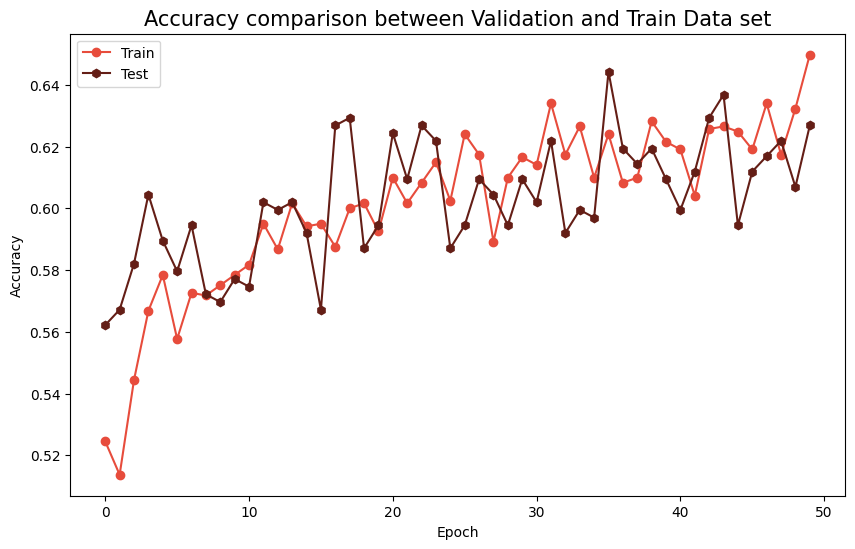

In [11]:
#Accuracy comparison between Validation and Train Data set
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'],color="#E74C3C",marker='o', label='Train')
plt.plot(history.history['val_accuracy'],color='#641E16',marker='h', label='Validation')
plt.title('Accuracy comparison between Validation and Train Data set',fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

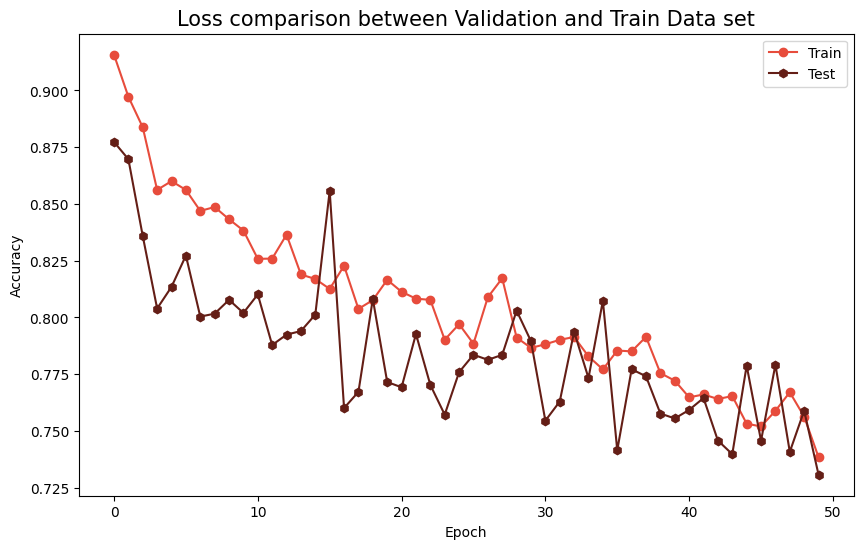

In [12]:
#Loss comparison between Validation and Train Data set
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],color="#E74C3C",marker='o')
plt.plot(history.history['val_loss'],color='#641E16',marker='h')
plt.title('Loss comparison between Validation and Train Data set',fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [13]:
from sklearn.metrics import classification_report

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)
print("Testing Loss:", loss)
print("Testing Accuracy:", accuracy)

# Generate predictions from the model
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)  # Convert predicted probabilities to class labels

# Get true labels from the generator
y_true = test_generator.labels  # Extract true labels from the test generator

# If 'labels' attribute is not available, you can try:
# y_true = test_generator.classes

# Print classification report for precision, recall, and F1-score
print(classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.6147 - loss: 0.7448
Testing Loss: 0.7482492923736572
Testing Accuracy: 0.6268656849861145
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
                precision    recall  f1-score   support

        Benign       0.55      0.78      0.64       152
     Malignant       0.75      0.66      0.70       208
normal thyroid       0.40      0.05      0.09        42

      accuracy                           0.64       402
     macro avg       0.57      0.49      0.48       402
  weighted avg       0.64      0.64      0.62       402



In [14]:
# Save the model
model.save('CNN_model.h5')
print ("Model saved successfully!")

Model saved successfully!


In [15]:
import tensorflow as tf
import numpy as np
import os
from PIL import UnidentifiedImageError

# Constants
IMAGE_SIZE = (28, 28)
BATCH_SIZE = 32
CLASS_NAMES = ['Benign', 'Malignant', 'normal thyroid']
dataset_path = "/kaggle/input/algerian-thyroid-disease-image/dataset thyroid"

In [16]:
# Load dataset and normalize images
data_set = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_names=CLASS_NAMES,
    label_mode='int'
).map(lambda x, y: (x / 255.0, y))  # Normalize images

Found 1937 files belonging to 3 classes.


In [17]:
def load_images(dataset_path):
    images = []
    labels = []
    for variety in os.listdir(dataset_path):
        variety_path = os.path.join(dataset_path, variety)
        if os.path.isdir(variety_path):
            label = variety
            for image_file in os.listdir(variety_path):
                image_path = os.path.join(variety_path, image_file)
                try:
                    # Try to load image and convert it to a numpy array
                    image = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SIZE)
                    image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
                    images.append(image_array)
                    labels.append(label)
                except (UnidentifiedImageError, IOError) as e:
                    # Handle the error if the image is not valid or cannot be opened
                    print(f"Error loading image {image_path}: {e}")
    return np.array(images), np.array(labels)

In [18]:
images, labels = load_images(dataset_path)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

Error loading image /kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Benign/Tiroides3: [Errno 21] Is a directory: '/kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Benign/Tiroides3'
Error loading image /kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Malignant/Tiroides4: [Errno 21] Is a directory: '/kaggle/input/algerian-thyroid-disease-image/dataset thyroid/Malignant/Tiroides4'


In [19]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.25, random_state=42)

In [20]:
# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),  # Input shape depends on your image size and channels
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),  # Flatten the images in each time step
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4676 - loss: 0.9958 - val_accuracy: 0.5249 - val_loss: 0.9120
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5379 - loss: 0.9267 - val_accuracy: 0.5075 - val_loss: 0.8911
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5460 - loss: 0.8982 - val_accuracy: 0.5149 - val_loss: 0.8805
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5847 - loss: 0.8646 - val_accuracy: 0.5149 - val_loss: 0.8847
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5544 - loss: 0.8568 - val_accuracy: 0.5373 - val_loss: 0.8721
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5746 - loss: 0.8665 - val_accuracy: 0.5572 - val_loss: 0.8483
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5925 - loss: 0.8208 - val_accuracy: 0.5746 - val_loss: 0.8467
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6153 - loss: 0.8373 - val_accuracy: 0.5821 - val_loss

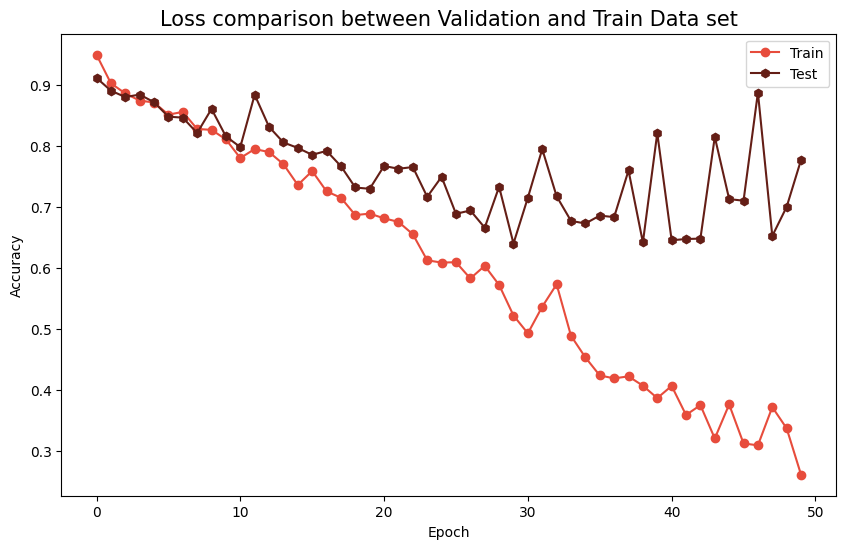

In [23]:
#Loss comparison between Validation and Train Data set
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],color="#E74C3C",marker='o')
plt.plot(history.history['val_loss'],color='#641E16',marker='h')
plt.title('Loss comparison between Validation and Train Data set',fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

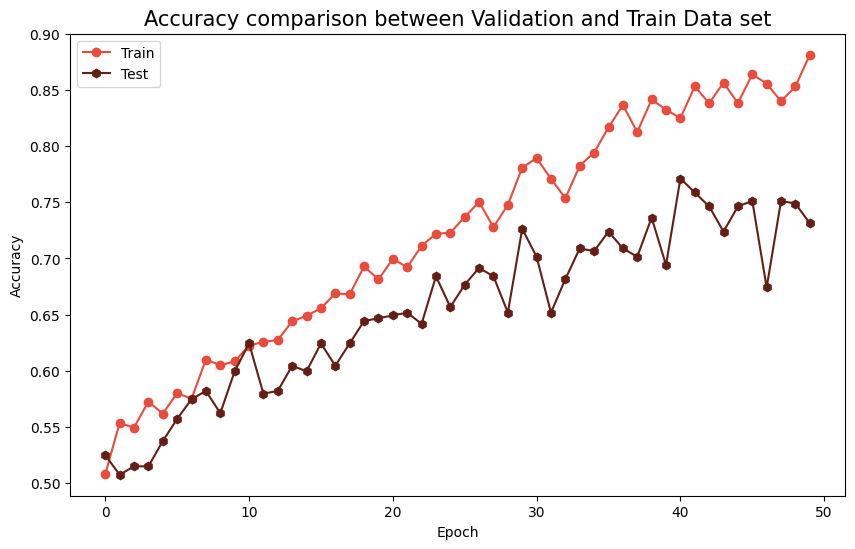

In [24]:
#Accuracy comparison between Validation and Train Data set
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'],color="#E74C3C",marker='o', label='Train')
plt.plot(history.history['val_accuracy'],color='#641E16',marker='h', label='Validation')
plt.title('Accuracy comparison between Validation and Train Data set',fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [25]:
from sklearn.metrics import classification_report

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Testing Loss:", loss)
print("Testing Accuracy:", accuracy)

# Generate predictions from the model
y_pred_prob = model.predict(X_test)  # Get predicted probabilities
y_pred_classes = y_pred_prob.argmax(axis=1)  # Convert probabilities to class labels

# Print classification report for precision, recall, and F1-score
print(classification_report(y_test, y_pred_classes))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7237 - loss: 0.7977 
Testing Loss: 0.7773849964141846
Testing Accuracy: 0.7313432693481445
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       169
           1       0.78      0.69      0.73       195
           2       0.30      0.39      0.34        38

    accuracy                           0.73       402
   macro avg       0.63      0.65      0.63       402
weighted avg       0.74      0.73      0.74       402



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


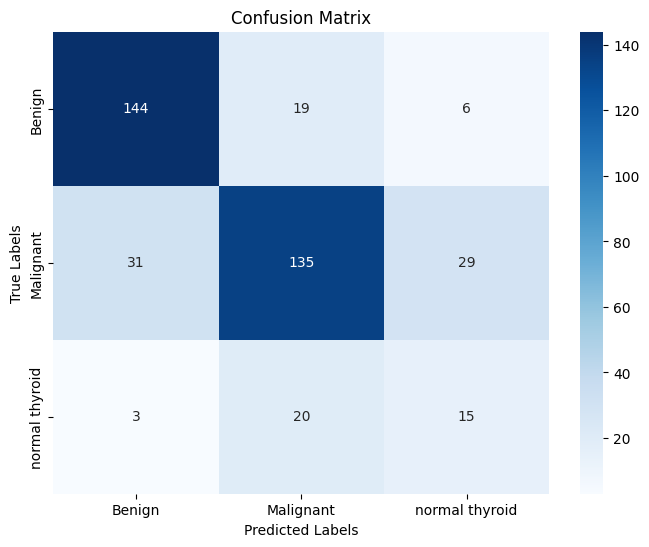

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Save the model
model.save('LSTM_model.h5')
print ("Model saved successfully!")

Model saved successfully!


In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Constants
IMAGE_SIZE_CNN = (50, 50)  # CNN input size
IMAGE_SIZE_LSTM = (28, 28)  # LSTM input size
BATCH_SIZE = 32
CLASS_NAMES = ['Benign', 'normal thyroid', 'Malignant']
EPOCHS = 50

# Load dataset and normalize images
data_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/algerian-thyroid-disease-image/dataset thyroid",
    shuffle=True,
    image_size=IMAGE_SIZE_CNN,
    batch_size=BATCH_SIZE,
    class_names=CLASS_NAMES,
    label_mode='int'
)

# Normalize the dataset
data_set = data_set.map(lambda x, y: (x / 255.0, y))

# Convert TensorFlow dataset to numpy arrays
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())  # Convert images to numpy arrays
        labels.append(label_batch.numpy())  # Convert labels to numpy arrays
    return np.concatenate(images), np.concatenate(labels)

# Convert TensorFlow dataset to numpy arrays
data_images, data_labels = dataset_to_numpy(data_set)

# Split the dataset into training and testing sets
train_images, val_images, train_labels, val_labels = train_test_split(data_images, data_labels, test_size=0.25, random_state=42)

# Resize the images for both CNN and LSTM models
def preprocess_data(images, cnn_size, lstm_size):
    cnn_images = []
    lstm_images = []

    for img in images:
        # Resize the images for CNN and LSTM input sizes
        cnn_resized = tf.image.resize(img, cnn_size).numpy()  # Resize for CNN
        lstm_resized = tf.image.resize(img, lstm_size).numpy()  # Resize for LSTM
        
        # Store the resized images in the lists
        cnn_images.append(cnn_resized)
        lstm_images.append(lstm_resized)
    
    return np.array(cnn_images), np.array(lstm_images)

# Prepare CNN and LSTM data for training and validation
train_cnn_data, train_lstm_data = preprocess_data(train_images, IMAGE_SIZE_CNN, IMAGE_SIZE_LSTM)
val_cnn_data, val_lstm_data = preprocess_data(val_images, IMAGE_SIZE_CNN, IMAGE_SIZE_LSTM)

# Now your CNN and LSTM data are ready for training the ensemble model
print("Prepared CNN and LSTM data.")

# Define your CNN and LSTM models (same as before)

# Load the pre-trained CNN model
def create_cnn_model(input_shape):
    cnn_input = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    cnn_model = tf.keras.Model(inputs=cnn_input, outputs=x)
    return cnn_model

# Load the pre-trained LSTM model
def create_lstm_model(input_shape):
    lstm_input = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(lstm_input)  # Flatten images in each time step
    x = tf.keras.layers.LSTM(128)(x)
    lstm_model = tf.keras.Model(inputs=lstm_input, outputs=x)
    return lstm_model

# Input shapes for the CNN and LSTM models
cnn_input_shape = (50, 50, 3)  # Example input shape for CNN
lstm_input_shape = (28, 28, 3)  # Example input shape for LSTM

# Create the CNN and LSTM models
cnn_model = create_cnn_model(cnn_input_shape)
lstm_model = create_lstm_model(lstm_input_shape)

# Combine (ensemble) the models
combined_input = tf.keras.layers.concatenate([cnn_model.output, lstm_model.output])

# Add fully connected layers after concatenation
x = tf.keras.layers.Dense(128, activation='relu')(combined_input)
x = tf.keras.layers.Dropout(0.5)(x)  # Regularization
output = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

# Define the final ensemble model
ensemble_model = tf.keras.Model(inputs=[cnn_model.input, lstm_model.input], outputs=output)

# Compile the model
ensemble_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the ensemble model
ensemble_model.summary()

# Train the model
history = ensemble_model.fit(
    [train_cnn_data, train_lstm_data],  # Inputs: CNN and LSTM data
    train_labels,  # Labels
    validation_data=([val_cnn_data, val_lstm_data], val_labels),  # Validation data
    epochs=50,
    batch_size=BATCH_SIZE
)

# Evaluate the model on the validation data
test_loss, test_accuracy = ensemble_model.evaluate([val_cnn_data, val_lstm_data], val_labels)
print(f"Validation Accuracy: {test_accuracy}")

# Save the ensemble model
ensemble_model.save('ensemble_model.h5')
print("Ensemble model saved successfully!")

Found 1937 files belonging to 3 classes.
Prepared CNN and LSTM data.


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 50, 50, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 48,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 24, 24,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 22, 22,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 11, 11,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 28, 84)    │          0 │ input_layer_3[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 7744)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    109,056 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7872)      │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │  1,007,744 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3)         │        387 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,136,579 (4.34 MB)

 Trainable params: 1,136,579 (4.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4560 - loss: 0.9569 - val_accuracy: 0.5216 - val_loss: 0.8680
Epoch 2/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5507 - loss: 0.8825 - val_accuracy: 0.6495 - val_loss: 0.8110
Epoch 3/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5762 - loss: 0.8546 - val_accuracy: 0.6495 - val_loss: 0.7803
Epoch 4/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6114 - loss: 0.8135 - val_accuracy: 0.6124 - val_loss: 0.7887
Epoch 5/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6289 - loss: 0.7601 - val_accuracy: 0.6660 - val_loss: 0.7455
Epoch 6/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6431 - loss: 0.7340 - val_accuracy: 0.6392 - val_loss: 0.7503
Epoch 7/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6822 - loss: 0.6764 - val_accuracy: 0.6309 - val_loss: 0.7574
Epoch 8/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7120 - loss: 0.6340 - val_accuracy: 0.6742 - val_loss

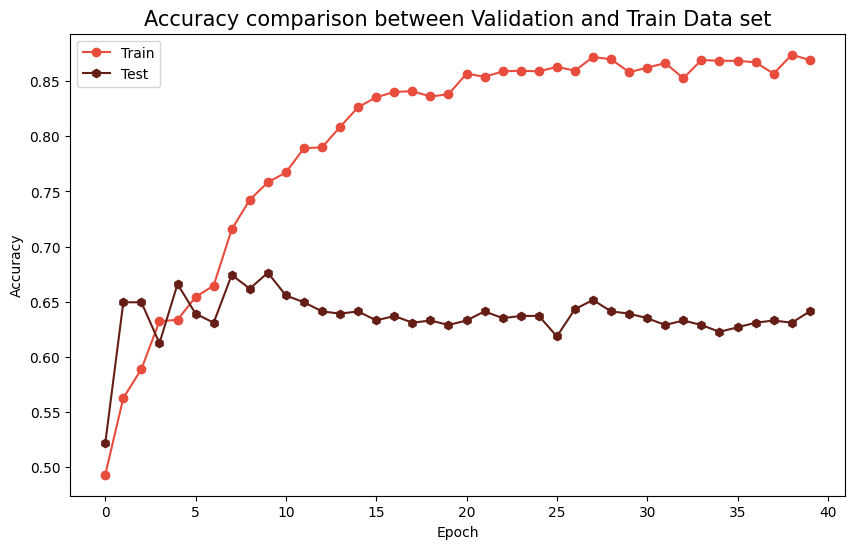

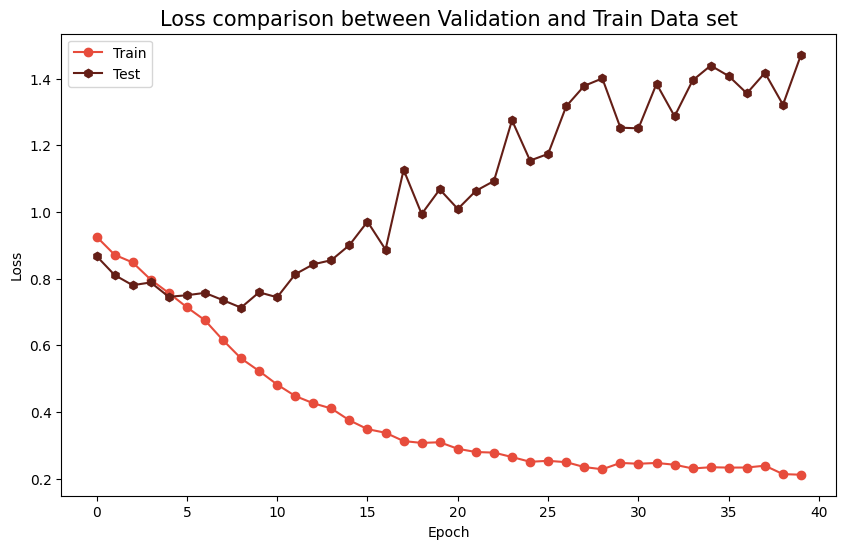

In [29]:
# Plotting accuracy comparison
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], color="#E74C3C", marker='o', label='Train')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h', label='Validation')
plt.title('Accuracy comparison between Validation and Train Data set', fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

# Plotting loss comparison
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], color="#E74C3C", marker='o')
plt.plot(history.history['val_loss'], color='#641E16', marker='h')
plt.title('Loss comparison between Validation and Train Data set', fontsize=15)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


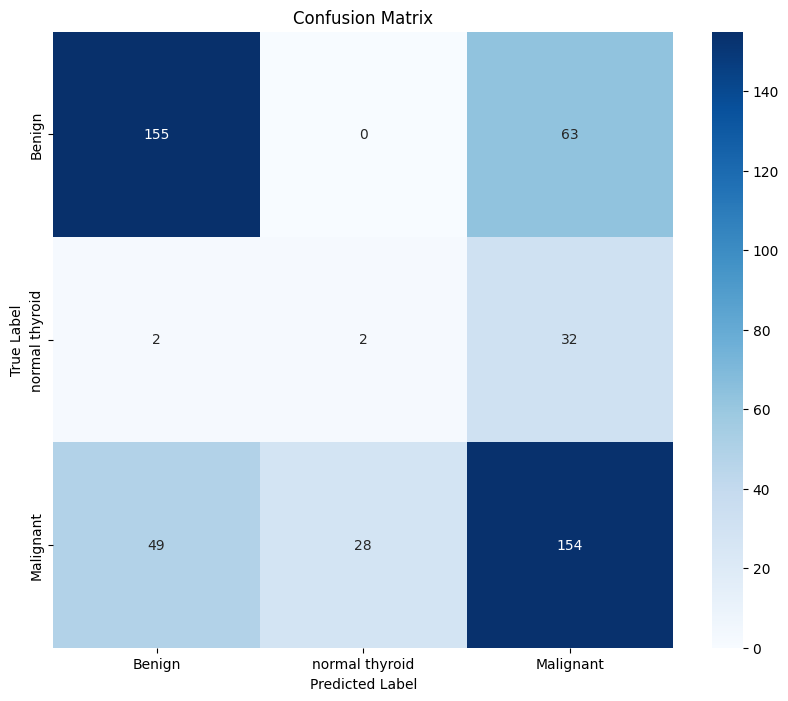

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Predict on the validation set with both CNN and LSTM inputs
y_pred = ensemble_model.predict([val_cnn_data, val_lstm_data])

# Step 2: Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 3: Generate the confusion matrix using validation labels
cm = confusion_matrix(val_labels, y_pred_classes)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()